In [39]:
from rdkit.Chem import PandasTools
from pathlib import Path
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [4]:
data = pd.read_csv(DATA / "PAINSandUNWANTED_removed_generated.csv")

In [5]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [7]:
data['fp'] = data['SMILES'].apply(smiles_to_fp)

In [9]:
#Load ML model
model = keras.models.load_model(DATA/'Activity_prediction.h5')
model.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 167)]             0         
                                                                 
 dense_88 (Dense)            (None, 32)                5376      
                                                                 
 dense_89 (Dense)            (None, 32)                1056      
                                                                 
 dense_90 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


2022-11-02 08:24:28.677814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-02 08:24:28.677858: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-02 08:24:28.677904: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (noteable): /proc/driver/nvidia/version does not exist
2022-11-02 08:24:28.678151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
Activity = []
for i in range(len(data)):
    Activity.append(model(np.expand_dims(data['fp'][i], axis=0)).numpy()[0][0])

In [31]:
Activity

[1.50347105e-05,
 2.6861213e-11,
 2.3795542e-06,
 2.2805548e-08,
 9.238981e-13,
 1.37066855e-14,
 0.000116223164,
 1.012789e-09,
 6.11166e-10,
 1.91185e-11,
 5.37412e-15,
 1.036401e-17,
 0.2995031,
 9.304896e-16,
 3.9887117e-12,
 2.7689762e-09,
 1.2407767e-09,
 2.2294133e-08,
 3.977364e-22,
 4.817416e-10,
 1.8586185e-14,
 8.394161e-12,
 1.9931207e-14,
 1.8885704e-08,
 2.8714203e-13,
 1.0521398e-17,
 1.4439926e-06,
 1.374435e-15,
 3.7864054e-15,
 2.4829958e-15,
 6.7499304e-06,
 3.0646709e-18,
 1.02721095e-16,
 2.297121e-05,
 2.6293867e-16,
 8.0956005e-21,
 9.300156e-09,
 1.1936228e-10,
 4.9257306e-08,
 1.3108362e-13,
 1.4067431e-13,
 7.9246485e-09,
 0.6005492,
 0.0009458011,
 1.349374e-11,
 1.8383153e-07,
 2.2846022e-07,
 2.9518357e-09,
 2.4277908e-08,
 2.0550043e-11,
 5.0790785e-11,
 2.2604128e-16,
 8.770264e-09,
 1.661198e-09,
 8.6680496e-10,
 6.3472285e-08,
 7.121302e-05,
 8.382298e-14,
 6.6812977e-09,
 1.7043693e-12,
 9.557998e-10,
 1.0286596e-09,
 1.5098137e-17,
 0.0003489409,
 4.6

In [32]:
data['activity'] = Activity

<AxesSubplot:>

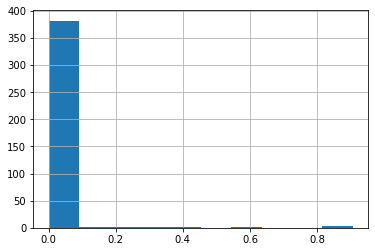

In [33]:
data['activity'].hist()

In [47]:
active = data[data['activity']>0.5]

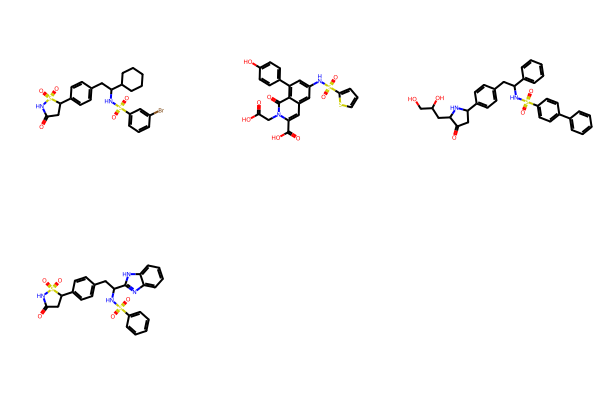

In [51]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(active, smilesCol="SMILES")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(active.ROMol)
)

## Compare structure to co-crystalized ligand and highest active comp in dataset

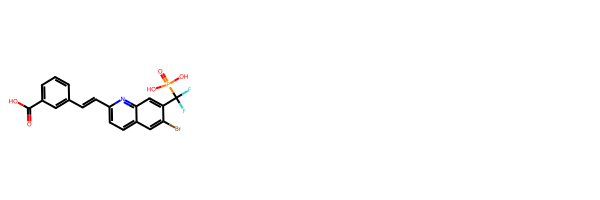

In [66]:
df = pd.read_csv(DATA/"PAINSandUNWANTED_removed.csv")
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="smiles")
Chem.Draw.MolsToGridImage(
    df.iloc[:1].ROMol
)

In [67]:
active.to_csv(DATA/'Active_generated_molecules.csv')